The goal of this notebook is to update avgSpec class to acept a file list including mesData and update genList to accept setup text file. 

In [9]:
from scipy.signal import butter, filtfilt, find_peaks, freqz, sosfilt
import glob
import os
from fnmatch import fnmatch
import h5py
import matplotlib
%matplotlib widget
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 
import sys 
import multiprocessing
from multiprocessing import Pool
import time
import gc

sys.path.insert(0, '../../drlib/')
import drlib as dr



In [2]:
from collections import namedtuple
from datetime import datetime
from multiprocessing import Pool
import argparse
import bisect
import configparser
import multiprocessing as mp
import numpy as np
import time
import matplotlib.pyplot as plt 
import h5py as h5
import os
import pandas as pd
import sys 
"""
Convert the float parameters in the config file to floats
Parameters:
   aString: The string in the config file
Returns:
    holder (1D list): List of floats
"""
def getFloatBounds(aString):
    holder = aString[aString.index('[')+1:aString.index(']')]
    holder = holder.split(',')
    holder = [float(x) for x in holder]
    return holder

"""
Convert the date parameters in the config file to floats
Parameters:
   aString: The date string in the config file
Returns:
    holder (1D list): List of datetime objects written as month/day/year hour:minute:second.microseconds
"""
def getDateBounds(aString):
    holder = aString[aString.index('[')+1:aString.index(']')]
    holder = holder.split(',')
    holder = [datetime.strptime(x.strip(), '%m/%d/%Y %H:%M:%S.%f')  for x in holder]
    return holder

"""
Take in a config file and return a dictionary of bounds
Parameters:
   configFile: The config file
   configName: The name of the configuration setup
Returns:
    configDict (dictionary): Dictionary of bounds
"""
def getAllBounds(configFile, configName):
    configSetup = configparser.ConfigParser()
    configSetup.read(configFile)
    configDict = {}
    tempBounds = getFloatBounds(configSetup[configName]['Temperature'])
    freqBounds = getFloatBounds(configSetup[configName]['Frequency'])
    dateBounds = getDateBounds(configSetup[configName]['Date'])
    antWestBounds =  getFloatBounds(configSetup[configName]['AntennaWest'])
    antVertBounds = getFloatBounds(configSetup[configName]['AntennaVert'])
    antSouthBounds = getFloatBounds(configSetup[configName]['AntennaSouth'])
    antThetaBounds = getFloatBounds(configSetup[configName]['AntennaTheta'])
    antPhiBounds = getFloatBounds(configSetup[configName]['AntennaPhi'])
    measChoice = configSetup['TEST']['Measurement']
    configDict['Temp'] = tempBounds 
    configDict['Freq'] = freqBounds
    configDict['Date'] = dateBounds
    configDict['Ant'] = (antWestBounds, antVertBounds, antSouthBounds, antThetaBounds, antPhiBounds)
    configDict['Choice'] = measChoice
    return configDict

"""
Return the indices in the "database" that fall within the specified
bound. This function assumes that the database is ordered by the 
parameter being searched for.
Parameters:
   val: The value in the config file
   parsedList: List of the parameter being searched for (e.g. date/temperature/antenna position)
Returns:
    holderIndices: List of all the indices in the sorted list that fall in the bounds
"""
def parseOnce(val, parsedList):
    if len(parsedList) == 0:
        return []
    
    holderIndices = []
    if val[0] > val[1]:
        print('CONFUSED ORDERING')
        return []
    if val[0] == -1:
        startIndex = 0
    elif val[0] < parsedList[0]:
        startIndex = 0
    elif val[0] > parsedList[-1]:
        print('EMPTY LIST')
        return []
    else:
        startIndex = bisect.bisect_left(parsedList, val[0])
    if val[1] == -1:
        endIndex = len(parsedList)
    elif val[1] > parsedList[-1]:
        endIndex = len(parsedList)
    else:
        endIndex = bisect.bisect_right(parsedList, val[1])
    
    [holderIndices.append(x) for x in range(startIndex, endIndex)]    
    return holderIndices

"""
Obtain all the datasets that fall within the bounds given in the config
file.
Parameters:
   configFile: The name of the configuration file
   configName: The name of the configuration setup in the config file 
Returns:
    parsedList: List of all the parsed data files defined as a list of tuples
                of the form ((file number, save number), date, temperature, antenna position).)
                    - Date is a datetime object
                    - Antenna position is a tuple of the form (west, vertical, south, theta, phi)

"""
def getParsedList(configFile, configName, dbFile):
    allData = []
    configDict = getAllBounds(configFile, configName)
    with open(dbFile, 'r') as f:
        f.readline()
        for line in f:
            holder = line.split()
            holder = [x.replace(',', '') if counter > 0 else x for counter, x in enumerate(holder)]
            try:
                dateVal = datetime.strptime(holder[1] + ' ' + holder[2], '%Y-%m-%d %H:%M:%S.%f')
            except:
                dateVal = datetime.strptime(holder[1] + ' ' + holder[2], '%Y-%m-%d %H:%M:%S')

            tempVal = float(holder[3])
            antPos = (float(holder[4][1:]), float(holder[5]), float(holder[6]), float(holder[7]), float(holder[8][:-1]))
            fileNum = float(holder[0][1:holder[0].index(',')])
            runNum = float(holder[0][holder[0].index(',')+1:-2])
            allData.append(((fileNum, runNum), dateVal, tempVal, antPos))
    
    holderIndices = []
    allData = sorted(allData, key = lambda x: x[1])
    parsedList = allData
    for val in np.reshape(configDict['Date'], (-1, 2)):
        [holderIndices.append(x) for x in parseOnce(val, [x[1] for x in parsedList])]
    
    holderIndices = np.asarray([*set(holderIndices)])
    parsedList = [parsedList[x] for x in holderIndices]
    

# configDict['Ant'] = (antWestBounds, antVertBounds, antSouthBounds, antThetaBounds, antPhiBounds)
# allData.append(((fileNum, runNum), dateVal, tempVal, antPos, antPos))

    for antSortVal in range(len(configDict['Ant'])):
        parsedList = sorted(parsedList, key = lambda x: x[3][antSortVal])
        holderIndices = []
        for val in np.reshape(configDict['Ant'][antSortVal], (-1, 2)):
            [holderIndices.append(x) for x in parseOnce(val, [x[3][0] for x in parsedList])]

        holderIndices = np.asarray([*set(holderIndices)])
        parsedList = [parsedList[x] for x in holderIndices]

    parsedList = sorted(parsedList, key = lambda x: x[2])
    holderIndices = []
    for val in np.reshape(configDict['Temp'], (-1, 2)):
        [holderIndices.append(x) for x in parseOnce(val, [x[2] for x in parsedList])]
    
    holderIndices = np.asarray([*set(holderIndices)])
    parsedList = [parsedList[x] for x in holderIndices]  
    
    parsedList = sorted(parsedList, key=lambda x: (x[0][0], x[0][1]))
    return parsedList, configDict
    #[print(x) for x in parsedList]



#num_arrays = 100
num_processes = mp.cpu_count()
num_simulations = 1000
sentinel = None

"""
Read the associated files in the parsed file list and store the data in
a queue, which is written to a file. All this is done using multiprocessing
speed up the read times. 
Parameters:
   readQueue: The queue that contains all the files to be written to a file. Stored in the following
              structure: (file number, list of data tuples)
                - tuple is of the form (measurement number, tuple of parameters)
                    o Tuple of parameters is of the form 
                      (save number, date, temperature, antenna position, frequency, measurement choice)
                        x Date is a datetime object
                        x Antenna position is a tuple of the form (west, vertical, south, theta, phi)
                        x Measurement choice is a string that is either 'Antenna', 'Terminator', or 'Both'

   output: The name of the output queue. Stored in the following structure: (data, tuple of parameters)
                - data is an numpy array of either antenna or terminator data or two arrays
                  if the measurement choice is both
                - Tuple paramters is of the form (measurement number, tuple of parameters) exactly
                  like the read queue
    
    dataDir: The directory where the data files are stored
Returns:
    Nothing. Puts data in a queue

"""
def collectData(readQueue, output, dataDir):
    freqStep = 6.0*10**8/2**23
    antData = []
    termData = []
    for parsedVal in iter(readQueue.get, sentinel):
        aFile = 'data_' + str(parsedVal[0]) + '.h5'
        #print(parsedVal)
        for writeData in parsedVal[1]:
            #print('TEST: ' + str(writeData[0]))
            dataset = pd.read_hdf(dataDir + aFile, key = 'measdata_'+ str(writeData[0])) 
            startFreq = writeData[1][3][0]
            endFreq = writeData[1][3][1]
            startIndex = int(startFreq*10**6 / freqStep)
            endIndex = int(endFreq*10**6/freqStep)
            if writeData[1][4] == 'Antenna' or writeData[1][4] == 'Both':
                antData = np.asarray(dataset[dataset.keys()[1]])[startIndex:endIndex] #the other one
            if writeData[1][4] == 'Terminator' or writeData[1][4] == 'Both':
                termData =  np.asarray(dataset[dataset.keys()[0]])[startIndex:endIndex] #term or bicon 
            if len(antData) == 0:
                output.put((termData, writeData))
            elif len(termData) == 0:
                output.put((antData, writeData))
            else:
                output.put((antData, termData, writeData))
    
            antData = []
            termData = []
       
"""
Write the data stored in the output queue to an .h5 file. Right now, only a single .h5 file
is saved, which can get large very quickly if too small of a subset of data are taken
Parameters:
   output: The name of the output queue. Stored in the following structure: (data, tuple of parameters)
                - data is an numpy array of either antenna or terminator data or two arrays
                  if the measurement choice is both
                - Tuple paramters is of the form (measurement number, tuple of parameters) exactly
                  like the read queue
    Returns:
    Nothing. Saves data to an .h5 in the same directory as where the script is called (change this)

"""
def writeFiles(output):
    #hdf = pt.openFile('simulation.h5', mode='w')
    aFile = h5.File('/group/tysongrp/RQTest.h5', 'w')
    first = True
    biconCounter = 0
    termCounter = 0
    while True:
        data = output.get()
        if first:
            freqStep = 6.0*10**8/2**23
            freqs = np.asarray(range(len(data[0])))*freqStep
            aFile.create_dataset('Freqs', data = freqs)
            first = False    
        if data:
            if data[-1][1][4] == 'Both':
                dataBicon = aFile.create_dataset('bicon_' + str(biconCounter), data=data[0])
                dataBicon.attrs['Date'] = str(data[-1][1][0])
                dataBicon.attrs['Run'] = str(data[-1][0])
                dataBicon.attrs['Antenna West'] = str(data[-1][1][2][0])
                dataBicon.attrs['Antenna Vertical'] = str(data[-1][1][2][1])
                dataBicon.attrs['Antenna South'] = str(data[-1][1][2][2])
                dataBicon.attrs['Antenna Theta'] = str(data[-1][1][2][3])
                dataBicon.attrs['Antenna Phi'] = str(data[-1][1][2][4])
                dataBicon.attrs['Temperature'] = str(data[-1][1][1])

                dataTerm = aFile.create_dataset('term_' + str(termCounter), data =data[1])
                
                dataTerm.attrs['Date'] = str(data[-1][1][0])
                biconCounter += 1
                termCounter += 1
        else:
            break
    #hdf.close()

In [ ]:
if __name__ == '__main__':
    
    writeH5 = False
    # Name of the configuration file
    configFile = '/group/tysongrp/ConfigDR.ini'
    # Name of the setup in the configuration file
    configName = 'TEST'
    # Get a parsed list of file names and also saves bounds to a dictionary
    parsedList, configDict = getParsedList(configFile, configName)
    RQTextFile = './RQFiles.txt'
    with(open(RQTextFile, 'w') as f):
        f.write('FILE NUMBER  RUN NUMBER  FREQUENCY RANGE (MHZ)  DATE  TEMPERATURE  ANTENNA POSITION (W/V/S,THETA,PHI)\n')
        for aVal in parsedList:
            aDate = aVal[1].strftime('%Y-%m-%d %H:%M:%S.%f')
            f.write((str(aVal[0][0])+ '  ' + str(aVal[0][1]) + '  ' + str(aDate) + '  ' + str(configDict['Freq'][0]) + '-' + str(configDict['Freq'][1]) + '  ' + str(aVal[2]) + '  ' + str(aVal[3])) + '\n')
            #print(configDict['Freq'])
    
    if writeH5:
        parsedDict = {}
        # Create a dictionary of lists of tuples (see the description for collectData). Doing this
        # makes it possible to parallelize the read operation
        for val in parsedList:
            keyVal = str(int(val[0][0]))
            if keyVal not in parsedDict:
                parsedDict[keyVal] = []
            
            # This will make it a little annoying to add more parameters to cut on
            parsedDict[keyVal].append((int(val[0][1]), (val[1], val[2], val[3], configDict['Freq'], configDict['Choice']))) 

    
        # List of keys (file numbers) in the parameter dictionary
        parsedKeys = [aKey for aKey in parsedDict]
        dataDir = '/group/tysongrp/JulyRun_7-7-22/Data/'
        #for aKey in parsedDict:
        #    aFile = 'data_' + str(aKey) + '.h5'
        #    dataBin = h5.File(dataDir + aFile, 'r')
        #    for anAverage in parsedDict[aKey]:
        #        print(dataBin['measdata_' + str(anAverage[0])])

        # Create the read/write queues
        writeQueue = mp.Queue()
        readQueue = mp.Queue()
        # Add data to the read queue
        [readQueue.put((aKey, parsedDict[aKey])) for aKey in parsedKeys] 
        
        # Start the write process
        proc = mp.Process(target=writeFiles, args=(writeQueue, ))
        jobs = []
        proc.start()

        # Create the read processes
        for i in range(num_processes):
            p = mp.Process(target=collectData, args=(readQueue, writeQueue, dataDir))
            jobs.append(p)
            p.start()
        for i in range(num_processes):
            # Send the sentinal to tell Simulation to end
            readQueue.put(sentinel)
        for p in jobs:
            p.join()
        writeQueue.put(None)
        proc.join()



In [ ]:
#mkFileList updated


def mkFileList(dataDir, configFile, dbFile, configName):
    #get list of tuples, (file, measData) indicated in configFile 
    # in dataDir, pack data*.h5 named files into fileList

    '''
    Get a parsed list of file names and also saves bounds to a dictionary
    getParsed List
    Returns:
    parsedList: List of all the parsed data files defined as a list of tuples of the form 
        ((file number, save number), date, temperature, antenna position).)
        - Date is a datetime object
        - Antenna position is a tuple of the form (west, vertical, south, theta, phi)
    configDict: dict of info in the config file used to generate parsedList
        keys:
        -Temp (temperture)
        -Freq (frequancy range)
        -Date (datetime object)
        -Ant (position. tuple of the form (west, vertical, south, theta, phi))
    '''
    parsedList, configDict = getParsedList(configFile, configName, dbFile)

    dataDirContents = os.listdir(dataDir)
    dataDirContentsList = [file for file in dataDirContents if fnmatch(file, 'data*.h5')]

        



# Name of the configuration and database files
configFile = './ConfigDR.ini'
dbFile = './SearchableDatabase.txt'
# Name of the setup in the configuration file
configName = 'TEST'
dataDir = ('../../../../../drBiggerBoy/drData/Data')
mkFileList(dataDir, configFile, dbFile, configName)








print('length parsed list = ',len(parsedList))
print('length parsed list/735 data file = ', len(parsedList)/735)
print()
for element in parsedList:
    print(element)
    print()




In [13]:

class avgSpec:
    '''
    Inputs:
        parsedList(list):
        List of tuples of file numbers and info
        each entry is tuple of form
        (
        tuple(float(fileNumber), float(spectrumNumber),
        datetime object,
        float(temperature),
        (float(West), float(Vertical), float(South), float(Phi), float(Theta))
        ) 

        dataDir(string): 
        Realitive path to data directory

        numProc(int):
        Number of processes to open data files.

    Methods:
        compAvg: Main. calls avgMesData in parallel to average all files. Then calls
		        avgDataList to average these subspectra together into a master spectrum

		Internal functions to compute average spectra:
            avgMesData: worker. averages selected measData spectra from a single data file
            avgDataList: Takes spectra from avgMesData and computes a master average
            setSpecDictsAndFileList: converts parsedList to dicts and lists
            for use by other methods
		
    '''
    
    def __init__(self,
        parsedList,
        dataDir,
        numProc = 28,
        verbose = False):

        self.parsedList = parsedList
        self.dataDir = dataDir
        self.numProc = numProc
        self.verbose = verbose

        self.antData = np.zeros(2**23)
        self.termData = np.zeros(2**23)
        
        #can pull these out of data files later
        self.startFreq = 0
        self.stopFreq = 300
        numBins = 8388607
        self.freqs = np.linspace(self.startFreq, self.stopFreq, numBins)

        
        self.computeAvg(parsedList = self.parsedList)
     
    def setSpecDictsAndFileList(self):
        '''
        Converts parsedList to a fileList and specDicts (one for names, one for numbers)

        Sets: 
        fileList: list of str(fileName))
        specNumDict: dict. {int(fileNum) : list(int(specNum))}
        specNameDict: dict. {str(fileName) : list(str(specName)}

        Input:
        parsedList: list of tuples (float(fileNum), float(specNum))
        '''
        #tests
        if type(self.parsedList) != list:
            raise TypeError('parsedList is not a list!')
            
        #init stuff
        specList = []
        fileList = []
        specNameDict = {}
        specNumDict = {}

        parsedListOnlyIdx = [spec[0] for spec in self.parsedList]
        #itterate over parsedList, set unique file name/num as keys in dict. Fill
        #each key with lists of names/nums of mes data  
        for fileNumFloat, specNumFloat in parsedListOnlyIdx:
            #generate names/numbers for files/specs
            fileNum = int(fileNumFloat)
            specNum = int(specNumFloat)
            fileName = 'data_' + str(fileNum) + '.h5'
            specName = 'measdata_' + str(specNum)
            #stuff dicts
            specNumDict.setdefault((fileNum), []).append(specNum)
            specNameDict.setdefault((fileName), []).append(specName)
        #set dicts and fileNameList 
        self.fileNameList = list(specNameDict.keys())
        self.specNameDict = specNameDict
        self.specNumDict = specNumDict

    def avgMeasData(self, aFile):
        '''
        Worker function to open a data file and average SELECT measData. Called by computeAvg

        Parameters:
            self.dataDir (str): Location of files. Realitive path.
            aFile (tuple): specifies a spectrum. (fileName(str), measData(int)) 

        Returns:
            antData (1D np arr): averaged off spectrum (linear FFT units)
            termData (1D np arr): averaged on spectrum (linear FFT units)
            numAvgInDataFile (int): number of averages in data file.
        '''
        #init some parameters
        antData = np.zeros(2**23)
        termData = np.zeros(2**23)
        numDataSets = 0
        numAvgInDataFile = 0

        #itterate through file list and open h5 files in 'r(ead)' mode
        if self.verbose == True:
            print('ON FILE: ' + str(aFile[0]))
        dataBin = h5py.File(self.dataDir + aFile[0], 'r') #makes pointer to h5
        numAvgInMeasDataSet = int(dataBin.attrs['averages']) #total number of average for dataset



        for aKey in aFile[1][:]:
            dataset = pd.read_hdf(self.dataDir + aFile[0], key = aKey) #dataframe of ROACH data (check)
        # need to print and look at this
            termData +=  np.asarray(dataset[dataset.keys()[0]]) #term or bicon
            antData += np.asarray(dataset[dataset.keys()[1]]) #the other one
            numDataSets += 1
            numAvgInDataFile += numAvgInMeasDataSet

        antData /= numDataSets
        termData /= numDataSets
        
        return antData, termData, numAvgInDataFile

    def avgDataList(self):
        '''
        Parameters:
            self.dataList (list of len=self.fileList): Each element of dataList contains a len=3 tuple
                which contains (antData (arr of len=numBins), 
                                termData (arr of len=numBins), 
                                numAvgInDataFile (int))
        Sets:
            self.antData (1D np arr): averaged off spectrum (linear FFT units)
            self.termData (1D np arr): averaged on spectrum (linear FFT units) 		        
        NOTE: this takes about 2% of the time it takes to open files and avg 
            their spectra even though it is not parallized
        '''
     
        antData = np.zeros(2**23)
        termData = np.zeros(2**23)
        numDataFiles = 0

        for dataTuple in self.dataList:
            antData += dataTuple[0]
            termData += dataTuple[1]
            numDataFiles += 1
        
        self.antData = antData / numDataFiles
        self.termData = termData / numDataFiles



    def computeAvg(self, parsedList):
        '''
        Opens each file in fileList and computes an average of SELECTED measData in each data file.
        Then averages each of these averages together. 

        Parameters:
            self.fileList - list of strings of file names to be averaged
            self.specNameList - list of tuples of (str(fileName), str(specNam))
            self.specNumList - list of tuples of (int(fileNum), int(specNum))

        Returns:
            None

        Sets:
            self.dataList (list of len=self.fileList): Each element of dataList contains a len=3 tuple
                which contains (antData (arr of len=numBins), 
                                termData (arr of len=numBins), 
                                numAvgInDataFile (int))
             
        Calls:
            avgMeasDataAll(): worker function. Averages together ALL measData in a data file
        '''
        self.setSpecDictsAndFileList()
        print('Starting to open', len(self.fileNameList),
                'files and avgerage measData with', self.numProc, 'processes')
        tStart = time.time()
        if 1: #__name__ == '__main__': #does not import with name == main. Removing it fixes issue. Come back to this
            #Multiprocessing. Each process (pool) computes an 
            #average spectra on select spectra of a single data file's measData.
            pool = Pool(processes = self.numProc)
            self.dataList = pool.map(self.avgMeasData, list(self.specNameDict.items()))

            #Calculate total number of FFTs in returned spectra. Each data 
            #file returns number of FFTs in dataList[data file index][2]  
            self.totalNumAvg = 0
            for runningAverages in self.dataList:
                self.totalNumAvg += runningAverages[2]
        tMeasData = time.time()

        #print('Done opening. Now averaging dataFile arrays together') 
        self.avgDataList()
        tDone = time.time()

        del self.dataList
        gc.collect()

        print('time to open and avg mes data =', tMeasData - tStart)
        print('Done. Total time =', tDone - tStart)

In [18]:
# Name of the configuration and database files
configFile = './ConfigDR.ini'
dbFile = './SearchableDatabase.txt'
# Name of the setup in the configuration file
configName = 'DEFAULT'
dataDir = ('../../../../../drBiggerBoy/drData/Data/')


#demo parsedList
# parsedList = ([((1.,1.),'asdf'),((1.,2.),'asdf')])
parsedList, infoDict = getParsedList(configFile, configName, dbFile)
print('length parsed list =', len(parsedList))
print(parsedList[0])
print(infoDict)


length parsed list = 11776
((0.0, 0.0), datetime.datetime(2022, 7, 7, 12, 46, 11, 184000), 294.35, (140.0, 104.0, 200.0, 0.0, 45.0))
{'Temp': [-1.0, -1.0], 'Freq': [-1.0, -1.0], 'Date': [datetime.datetime(1970, 1, 1, 12, 0), datetime.datetime(2030, 1, 1, 12, 0)], 'Ant': ([-1.0, -1.0], [-1.0, -1.0], [-1.0, -1.0], [-1.0, -1.0], [-1.0, -1.0]), 'Choice': 'Both'}


In [19]:

specData = avgSpec(parsedList, dataDir, verbose=True)

Starting to open 736 files and avgerage measData with 28 processes
ON FILE: data_0.h5
ON FILE: data_7.h5
ON FILE: data_14.h5
ON FILE: data_21.h5
ON FILE: data_28.h5
ON FILE: data_35.h5
ON FILE: data_42.h5
ON FILE: data_49.h5
ON FILE: data_56.h5
ON FILE: data_63.h5
ON FILE: data_70.h5
ON FILE: data_77.h5
ON FILE: data_84.h5
ON FILE: data_91.h5
ON FILE: data_98.h5
ON FILE: data_105.h5
ON FILE: data_112.h5
ON FILE: data_119.h5
ON FILE: data_126.h5
ON FILE: data_133.h5
ON FILE: data_140.h5
ON FILE: data_147.h5
ON FILE: data_154.h5
ON FILE: data_161.h5
ON FILE: data_168.h5
ON FILE: data_175.h5
ON FILE: data_182.h5
ON FILE: data_189.h5
ON FILE: data_1.h5
ON FILE: data_8.h5
ON FILE: data_22.h5
ON FILE: data_15.h5
ON FILE: data_36.h5
ON FILE: data_43.h5
ON FILE: data_29.h5
ON FILE: data_50.h5
ON FILE: data_57.h5
ON FILE: data_85.h5
ON FILE: data_64.h5
ON FILE: data_71.h5
ON FILE: data_78.h5
ON FILE: data_92.h5
ON FILE: data_113.h5
ON FILE: data_99.h5
ON FILE: data_106.h5
ON FILE: data_120.h5
O

In [26]:
np.save('run1_antData_avgAll11776Spectra_gitignore', specData.antData)
np.save('run1_termData_avgAll11776Spectra_gitignore', specData.termData)
np.save('run1_freqData_avgAll11776Spectra_gitignore', specData.freqs)

In [5]:
parsedList, infoDict = getParsedList(configFile, configName, dbFile)
print('length parsed list =', len(parsedList))
specData.computeAvg(parsedList)

length parsed list = 81
Starting to open 6 files and avgerage measData with 28 processes
ON FILE: data_32.h5
ON FILE: data_33.h5
ON FILE: data_34.h5
ON FILE: data_35.h5
ON FILE: data_36.h5
ON FILE: data_37.h5
time to open and avg mes data = 18.3856463432312
Done. Total time = 18.52050542831421


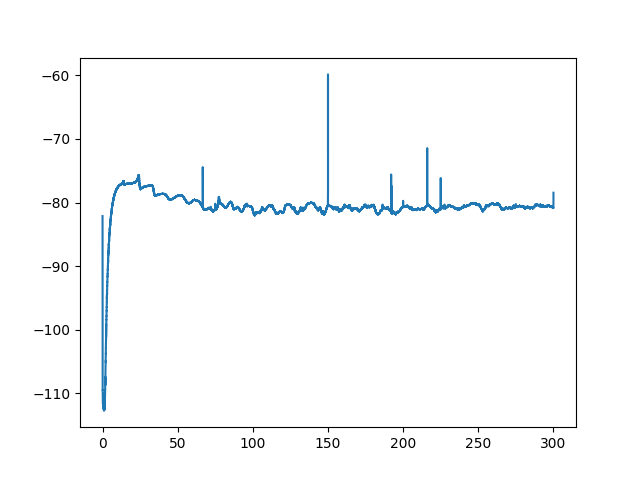

In [27]:
%matplotlib widget
ant = np.load('run1_antData_avgAll11776Spectra_gitignore.npy')
plt.plot(specData.freqs,dr.fft2dBm(ant[1:]))

In [ ]:
fullList = [1,2,3,4,5]
subSet = [1,3]

testDict = {6 : subSet}

testDict.update({5 : 'test'})
print(testDict)
for i in testDict:
    print(i)

In [ ]:
parsedList = ([((1.,1.),'asdf'), ((1.,2.), 'asdf'), ((2.,3.),'asdf'), \
((69.,420.),'asdf'), ((1., 123.),'asdf')])



In [ ]:
parsedListOnlyIdx = [spec[0] for spec in parsedList]



if type(parsedList) != list:
    raise TypeError('parsedList is not a list!')
'''
for spec in parsedList:
    if type(spec) != tuple:
        raise TypeError('parsedList contains non tutples')
    if type(spec[0]) != int and type(spec[0]) != float:
        raise TypeError('file numbers are not numbers')
    if type(spec[1]) == int or type(spec[1]) ==  float:
        raise TypeError('spec numbers are not numbers')
'''


specList = []
fileList = []
specNameDict = {}
specNumDict = {}

for fileNumFloat, specNumFloat in parsedListOnlyIdx:
    fileNum = int(fileNumFloat)
    specNum = int(specNumFloat)
    fileName = 'data_' + str(fileNum) + '.h5'
    specName = 'mesdata_' + str(specNum)
            
    specNumDict.setdefault((fileNum), []).append(specNum)
    specNameDict.setdefault((fileName), []).append(specName)
fileNameList = list(specNameDict.keys())

specNameDict.items()

